In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from portfolio_env_framework import *
from data_utils import *
from rewards import *

## Naive Equal

In [2]:
class NaiveEqualPolicy:
  def reset(self):
    pass

  def predict(self, obs) -> npt.NDArray:
    return np.ones(obs['weights'].shape) / obs['weights'].shape[0]

In [3]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2018) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((6, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [4]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+10]]
mus = []

model = NaiveEqualPolicy()
for i in range(900):
    action = model.predict(obs)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+10])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+10]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


In [6]:
import pickle as pkl
with open('naive_equal_results.pkl', 'wb') as f:
  pkl.dump({
    'port_val': port_val,
    'snp_val': snp_val,
    'times_arr': times_arr,
    'mus': mus,
  }, f)


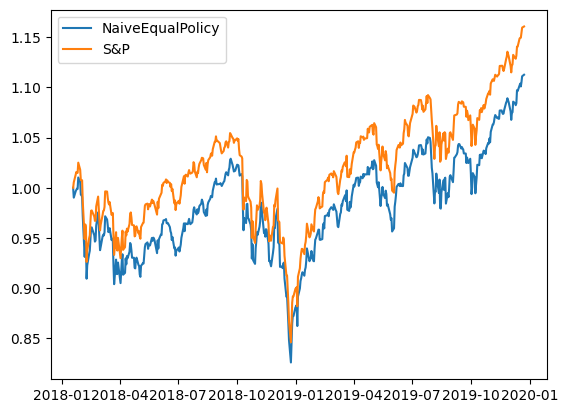

In [7]:
plt.plot(times_arr, np.array(port_val), label='NaiveEqualPolicy')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Uniform Buy-and-Hold

In [8]:
# read all data
df = read_crsp_data()
full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))

# only include stocks that are present in all dates and in both datasets
df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
def is_max_val_count(ticker: str) -> bool:
  return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
df = df[(df.date.dt.year >= 2018) & (df.date.dt.year <= 2019)]
times = df.date.unique()[1:]
tickers = df.TICKER.unique()
full_df = full_df[full_df.apply(lambda row: (row.TICKERH in tickers), axis=1)]

# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)

# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
ret = np.log(stock_df.pct_change().iloc[1:, :] + 1)

# read index data and compute volatilities
idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
  'DATE': 'string',
  'vwretd': float
})
idx_df.DATE = pd.to_datetime(idx_df.DATE)
idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
idx_df.set_index('DATE', inplace=True)
idx_df = idx_df

num_time_periods = len(times)-15-1
universe_size = len(tickers)
print(f"{universe_size=}")

universe_size=79


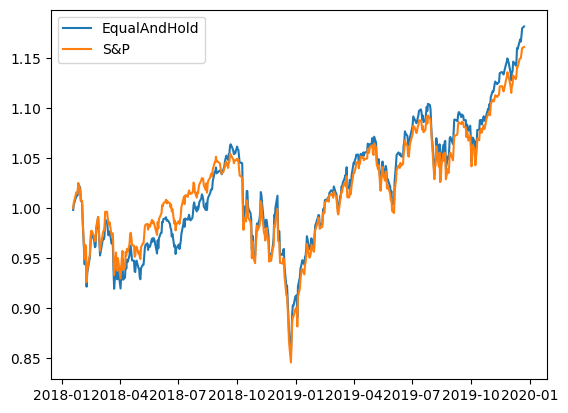

In [10]:
rets = np.exp(ret.loc[times_arr,:]).cumprod(axis=0).mean(axis=1)
plt.plot(times_arr, rets, label='EqualAndHold')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [11]:
import pickle as pkl
with open('equal_and_hold_results.pkl', 'wb') as f:
  pkl.dump({
    'port_val': rets,
    'snp_val': snp_val,
    'times_arr': times_arr,
    'mus': mus,
  }, f)

## Best Historical Asset

In [2]:
# read all data
df = read_crsp_data()
full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))

# only include stocks that are present in all dates and in both datasets
df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
def is_max_val_count(ticker: str) -> bool:
  return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2017)]
times = df.date.unique()[1:]
tickers = df.TICKER.unique()
full_df = full_df[full_df.apply(lambda row: (row.TICKERH in tickers), axis=1)]

# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)

# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
ret = np.log(stock_df.pct_change().iloc[1:, :] + 1)

num_time_periods = len(times)-15-1
universe_size = len(tickers)
print(f"{universe_size=}")

universe_size=79


In [3]:
best_stock_profit = ret.columns[np.exp(ret).prod(axis=0).argmax()]
best_stock_sharpe = ret.columns[(np.exp(ret).mean(axis=0) / np.exp(ret).std(axis=0)).argmax()]

In [6]:
best_stock_profit, best_stock_sharpe

('NFLX', 'PEP')

In [14]:
# read all data
df = read_crsp_data()
full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))

# only include stocks that are present in all dates and in both datasets
df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
def is_max_val_count(ticker: str) -> bool:
  return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
df = df[(df.date.dt.year >= 2018) & (df.date.dt.year <= 2019)]
times = df.date.unique()[1:]
tickers = df.TICKER.unique()
full_df = full_df[full_df.apply(lambda row: (row.TICKERH in tickers), axis=1)]

# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)

# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
ret = np.log(stock_df.pct_change().iloc[1:, :] + 1)

# read index data and compute volatilities
idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
  'DATE': 'string',
  'vwretd': float
})
idx_df.DATE = pd.to_datetime(idx_df.DATE)
idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
idx_df.set_index('DATE', inplace=True)
idx_df = idx_df

num_time_periods = len(times)-15-1
universe_size = len(tickers)
print(f"{universe_size=}")

universe_size=79


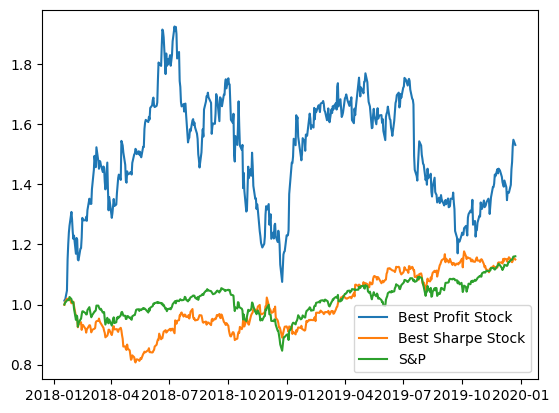

In [16]:
rets = np.exp(ret.loc[times_arr, best_stock_profit]).cumprod()
plt.plot(times_arr, rets, label='Best Profit Stock')
rets = np.exp(ret.loc[times_arr, best_stock_sharpe]).cumprod()
plt.plot(times_arr, rets, label='Best Sharpe Stock')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [17]:
rets = np.exp(ret.loc[times_arr, best_stock_profit]).cumprod()
import pickle as pkl
with open('best_profit_stock_results.pkl', 'wb') as f:
  pkl.dump({
    'port_val': rets,
    'snp_val': snp_val,
    'times_arr': times_arr,
    'mus': mus,
  }, f)

In [18]:
rets = np.exp(ret.loc[times_arr, best_stock_sharpe]).cumprod()
import pickle as pkl
with open('best_sharpe_stock_results.pkl', 'wb') as f:
  pkl.dump({
    'port_val': rets,
    'snp_val': snp_val,
    'times_arr': times_arr,
    'mus': mus,
  }, f)

## OLMAR

In [2]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2018) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = []
        for i in range(10):
            x = self.stock_df.loc[self.times[t+i], self.tickers].to_numpy().flatten()
            s.append(np.append(x, 1.0))
        return {'past_prices': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [11]:
# class OLMARPolicy:
#   def __init__(self, epsilon: float = 5):
#     self.epsilon = epsilon

#   @staticmethod
#   def OLMAR(epsilon: float, w: npt.NDArray, x_tilde: npt.NDArray, b: npt.NDArray):
#     xbar = np.sum(x_tilde) / len(x_tilde)
#     lmbda = np.maximum(0, (epsilon - b @ x_tilde) / (np.linalg.norm(x_tilde - xbar)**2))
#     b_new = b + lmbda * (x_tilde - xbar)
#     # b_new = np.clip(b_new, 0, 1)
#     return scipy.optimize.minimize(
#       lambda b: np.linalg.norm(b - b_new)**2,
#       x0=b_new,
#       bounds=[(0, 1)]*len(b),
#       constraints=[
#         {
#           'type': 'eq',
#           'fun': lambda b: np.sum(b) - 1
#         },
#         {
#           'type': 'ineq',
#           'fun': lambda b: np.sum(b * xbar) - epsilon
#         }
#       ]
#     ).x
#     return b_new / np.sum(b_new)
  
#   def predict(self, obs) -> npt.NDArray:
#     xs = obs['past_prices']
#     w = len(xs)
#     x_tilde = sum(xs) / (w * xs[0])
#     return self.OLMAR(self.epsilon, w, x_tilde, obs['weights'])

In [3]:
# https://github.com/Marigold/universal-portfolios/blob/master/universal/tools.py
def simplex_proj(y):
    """Projection of y onto simplex."""
    m = len(y)
    bget = False

    s = sorted(y, reverse=True)
    tmpsum = 0.0

    for ii in range(m - 1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if tmax >= s[ii + 1]:
            bget = True
            break

    if not bget:
        tmax = (tmpsum + s[m - 1] - 1) / m

    return np.maximum(y - tmax, 0.0)

In [4]:
# https://github.com/Marigold/universal-portfolios/blob/master/universal/algos/olmar.py
class OLMARPolicy:
  def __init__(self, epsilon: float = 5, alpha: float = 0.5):
    self.epsilon = epsilon
    self.alpha = alpha
  
  @staticmethod
  def OLMAR(epsilon: float, w: npt.NDArray, x_tilde: npt.NDArray, b: npt.NDArray) -> npt.NDArray:
    xbar = np.sum(x_tilde) / len(x_tilde)
    excess = x_tilde - xbar
    denom = (excess * excess).sum()
    if denom != 0:
      lam = max(0.0, (epsilon - np.dot(b, x_tilde)) / denom)
    else:
      lam = 0
    b = b + lam * (excess)
    return simplex_proj(b)
  
  def predict(self, obs) -> npt.NDArray:
    xs = obs['past_prices']
    w = len(xs)
    x_tilde = sum(xs) / (w * xs[-1])
    return self.OLMAR(self.epsilon, w, x_tilde, obs['weights'])

In [5]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    rm=ProfitReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)

models = [
    OLMARPolicy(epsilon=1.1),
    # OLMARPolicy(epsilon=1.5),
    # OLMARPolicy(epsilon=2.0),
    # OLMARPolicy(epsilon=3),
    # OLMARPolicy(epsilon=5),
    # OLMARPolicy(epsilon=10),
    # OLMARPolicy(epsilon=20),
    # OLMARPolicy(epsilon=50),
]
port_vals = []

for model in models:
  obs, _ = env.reset()

  port_val = [1.0]
  snp_val = [1.0]
  actions = []
  ys = []
  times_arr = [env.dm.times[env.t+10]]
  mus = []

  for i in range(900):
      action = model.predict(obs)
      actions.append(action)
      # print(f"external {action=}")
      obs, rewards, terminated, truncated, info = env.step(action)
      ys.append(env.y)
      mus.append(env.mu)
      times_arr.append(env.dm.times[env.t+10])
      port_val.append(info['port_val'])
      snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+10]].vwretd.values[0]))
      if terminated:
          break
  
  port_vals.append(port_val)

self.universe_size=79


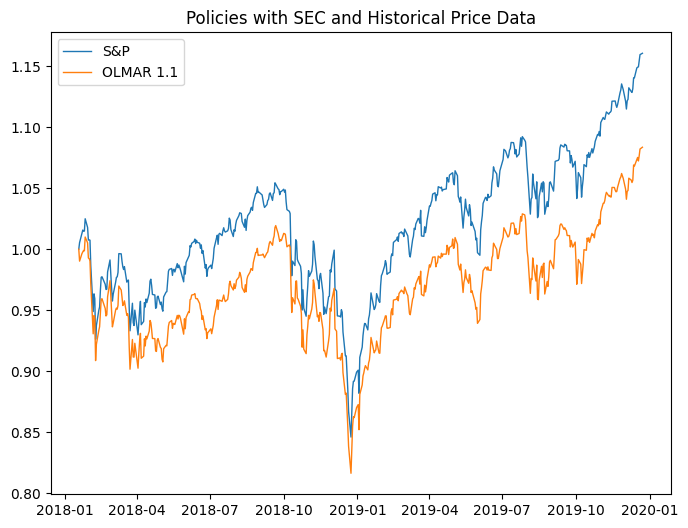

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(times_arr, np.array(snp_val), label='S&P', lw=1)
for i, model in enumerate(models):
    plt.plot(times_arr, np.array(port_vals[i]), label=f'OLMAR {model.epsilon}', lw=1)
# plt.yscale('log')
plt.legend()
plt.title('Policies with SEC and Historical Price Data')
plt.show()

In [7]:
import pickle as pkl
with open(f'olmar_1.1_results_decent.pkl', 'wb') as f:
  pkl.dump({
    'port_val': port_vals[0],
    'snp_val': snp_val,
    'times_arr': times_arr,
    'mus': mus,
  }, f)

In [7]:
# import pickle as pkl
# for i, model in enumerate(models):
#     with open(f'olmar_{model.epsilon}_results_noclip.pkl', 'wb') as f:
#       pkl.dump({
#         'port_val': port_vals[i],
#         'snp_val': snp_val,
#         'times_arr': times_arr,
#         'mus': mus,
#       }, f)

## WMAMR

In [8]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2018) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = []
        for i in range(10):
            x = self.stock_df.loc[self.times[t+i], self.tickers].to_numpy().flatten()
            s.append(np.append(x, 1.0))
        return {'past_prices': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [6]:
# class WMAMRPolicy:
#   def __init__(self, epsilon: float = 5):
#     self.epsilon = epsilon

#   @staticmethod
#   def WMAMR(epsilon: float, w: npt.NDArray, x_tilde: npt.NDArray, b: npt.NDArray):
#     xbar = np.sum(x_tilde) / len(x_tilde)
#     lmbda = np.maximum(0, (epsilon - b @ x_tilde) / (np.linalg.norm(x_tilde - xbar)**2))
#     b_new = b + lmbda * (x_tilde - xbar)
#     b_new = np.clip(b_new, 0, 1)
#     return scipy.optimize.minimize(
#       lambda b: np.linalg.norm(b - b_new)**2,
#       x0=b_new,
#       bounds=[(0, 1)]*len(b),
#       constraints=[
#         {
#           'type': 'eq',
#           'fun': lambda b: np.sum(b) - 1
#         },
#         {
#           'type': 'ineq',
#           'fun': lambda b: epsilon - np.sum(b * xbar)
#         }
#       ]
#     ).x
#     return b_new / np.sum(b_new)
  
#   def predict(self, obs) -> npt.NDArray:
#     xs = obs['past_prices']
#     w = len(xs)
#     x_tilde = sum(xs) / (w * xs[0])
#     return self.WMAMR(self.epsilon, w, x_tilde, obs['weights'])

In [9]:
class WMAMRPolicy:
  def __init__(self, epsilon: float = 5):
    self.epsilon = epsilon

  @staticmethod
  def WMAMR(epsilon: float, w: npt.NDArray, x_tilde: npt.NDArray, b: npt.NDArray):
    xbar = np.sum(x_tilde) / len(x_tilde)
    le = max(0.0, np.dot(b, x_tilde) - epsilon)
    # lam = le / np.linalg.norm(x_tilde - xbar)**2
    # lam = min(500, le / np.linalg.norm(x_tilde - xbar)**2)
    lam = le / (np.linalg.norm(x_tilde - xbar)**2 + 0.5 / 500)
    lam = min(100000, lam)
    b = b - lam * (x_tilde - xbar)
    return simplex_proj(b)
  
  def predict(self, obs) -> npt.NDArray:
    xs = obs['past_prices']
    w = len(xs)
    x_tilde = sum(xs) / (w * xs[0])
    return self.WMAMR(self.epsilon, w, x_tilde, obs['weights'])

In [10]:
# env = PortfolioEnvWithTCost(
#     dm=TestDataManager(),
#     rm=ProfitReward(),
#     cp=0.01,#0.10/365,
#     cs=0.01,#0.10/365
# )

models = [
    # WMAMRPolicy(epsilon=0.1),
    # WMAMRPolicy(epsilon=0.3),
    # WMAMRPolicy(epsilon=0.5),
    # WMAMRPolicy(epsilon=0.7),
    # WMAMRPolicy(epsilon=1.0001),
    WMAMRPolicy(epsilon=1.1),
]
port_vals = []

for model in models:
  obs, _ = env.reset()

  port_val = [1.0]
  snp_val = [1.0]
  actions = []
  ys = []
  times_arr = [env.dm.times[env.t+10]]
  mus = []

  for i in range(900):
      action = model.predict(obs)
      actions.append(action)
      # print(f"external {action=}")
      obs, rewards, terminated, truncated, info = env.step(action)
      ys.append(env.y)
      mus.append(env.mu)
      times_arr.append(env.dm.times[env.t+10])
      port_val.append(info['port_val'])
      snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+10]].vwretd.values[0]))
      if terminated:
          break
  
  port_vals.append(port_val)

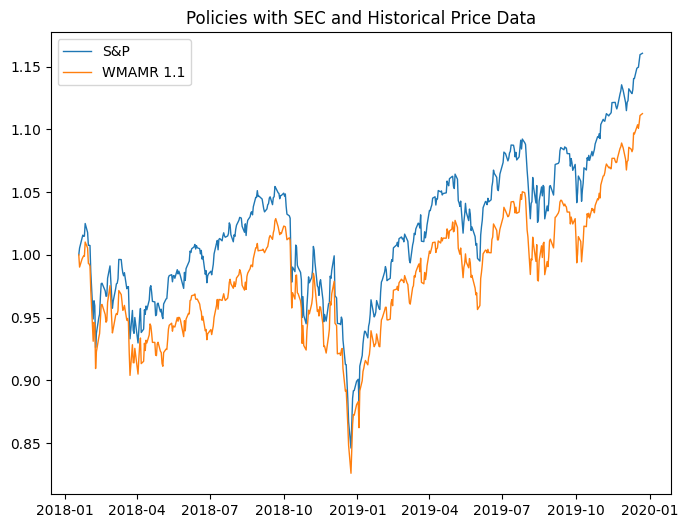

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(times_arr, np.array(snp_val), label='S&P', lw=1)
for i, model in enumerate(models):
    plt.plot(times_arr, np.array(port_vals[i]), label=f'WMAMR {model.epsilon}', lw=1)
# plt.yscale('log')
plt.legend()
plt.title('Policies with SEC and Historical Price Data')
plt.show()

In [12]:
with open(f'wmamr_1.1_results_decent.pkl', 'wb') as f:
  pkl.dump({
    'port_val': port_vals[0],
    'snp_val': snp_val,
    'times_arr': times_arr,
    'mus': mus,
  }, f)

In [41]:
# for i, model in enumerate(models):
#     with open(f'wmamr_{model.epsilon}_results_correct.pkl', 'wb') as f:
#       pkl.dump({
#         'port_val': port_vals[i],
#         'snp_val': snp_val,
#         'times_arr': times_arr,
#         'mus': mus,
#       }, f)